In [17]:
import os
import numpy as np
from PIL import Image
import tifffile
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import random

In [18]:
data_path = r'/content/drive/MyDrive/AI/satalite data/data'
images_path = os.path.join(data_path, 'images')
masks_path = os.path.join(data_path, 'labels')

In [19]:
def load_and_normalize_tiff(image_path):
    image = tifffile.imread(image_path)

    if len(image.shape) == 3:
        if image.shape[0] == 12:
            image = np.transpose(image, (1, 2, 0))

    normalized_image = np.zeros_like(image, dtype=np.float32)


    for layer in range(image.shape[2]):
        layer_data = image[:, :, layer].astype(np.float32)
        layer_min = np.min(layer_data)
        layer_max = np.max(layer_data)

        if layer_max > layer_min:
            normalized_image[:, :, layer] = (layer_data - layer_min) / (layer_max - layer_min)
        else:
            normalized_image[:, :, layer] = 0

    return normalized_image

In [20]:
def load_mask(mask_path):

    mask = Image.open(mask_path)
    mask = np.array(mask)


    if len(mask.shape) == 3:
        mask = mask[:, :, 0]

    return mask

In [21]:
def load_full_dataset():

    print("Loading full dataset...")
    images = []
    masks = []

    for i in range(306):
        image_file = os.path.join(images_path, f"{i}.tif")
        mask_file = os.path.join(masks_path, f"{i}.png")

        if os.path.exists(image_file) and os.path.exists(mask_file):
            try:
                image = load_and_normalize_tiff(image_file)
                mask = load_mask(mask_file)

                images.append(image)
                masks.append(mask)

                if (i + 1) % 50 == 0: # Print progress every 50 images
                    print(f"Loaded {i + 1}/306 images...")

            except Exception as e:
                print(f"Error loading image {i}: {str(e)}")
        else:
            print(f"Missing files for index {i}")

    images = np.array(images)
    masks = np.array(masks)

    print(f"Dataset loaded: {len(images)} images")
    print(f"Images shape: {images.shape}")
    print(f"Masks shape: {masks.shape}")

    return images, masks

In [22]:
def visualize_all_layers(images, masks, sample_idx=None):

    if sample_idx is None:
        sample_idx = random.randint(0, len(images) - 1)

    print(f"Visualizing sample {sample_idx}")

    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    fig.suptitle(f'Sample {sample_idx}: All 12 Layers + Segmentation Mask', fontsize=16)

    for i in range(12):
        row = i // 4
        col = i % 4
        axes[row, col].imshow(images[sample_idx][:, :, i], cmap='gray')
        axes[row, col].set_title(f'Layer {i}')
        axes[row, col].axis('off')

    axes[3, 0].imshow(masks[sample_idx], cmap='viridis')
    axes[3, 0].set_title('Segmentation Mask')
    axes[3, 0].axis('off')

    for i in range(1, 4):
        axes[3, i].axis('off')

    plt.tight_layout()
    plt.show()

    unique_classes = np.unique(masks[sample_idx])
    print(f"Unique classes in mask: {unique_classes}")
    print(f"Class distribution: {[(cls, np.sum(masks[sample_idx] == cls)) for cls in unique_classes]}")


In [23]:
def split_dataset(images, masks, test_size=0.05, val_size=0.15, random_state=42):

    print("Splitting dataset...")

    X_temp, X_test, y_temp, y_test = train_test_split(
        images, masks, test_size=test_size, random_state=random_state
    )

    val_size_adjusted = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size_adjusted, random_state=random_state
    )

    print(f"Train set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")

    return X_train, X_val, X_test, y_train, y_val, y_test


In [24]:
def unet_model(input_shape, num_classes):

    inputs = layers.Input(shape=input_shape)


    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D(2)(c1)


    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D(2)(c2)


    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D(2)(c3)


    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D(2)(c4)


    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(c5)

    u6 = layers.Conv2DTranspose(512, 2, strides=2, padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(c9)

    model = Model(inputs, outputs)
    return model


In [25]:
def attention_gate(F_g, F_l, F_int):


    g = layers.Conv2D(F_int, 1, strides=1, padding='same')(F_g)
    g = layers.BatchNormalization()(g)


    x = layers.Conv2D(F_int, 1, strides=1, padding='same')(F_l)
    x = layers.BatchNormalization()(x)


    psi = layers.add([g, x])
    psi = layers.Activation('relu')(psi)

    psi = layers.Conv2D(1, 1, strides=1, padding='same')(psi)
    psi = layers.BatchNormalization()(psi)
    psi = layers.Activation('sigmoid')(psi)

    return layers.multiply([F_l, psi])


In [26]:
def attention_unet_model(input_shape, num_classes):


    inputs = layers.Input(shape=input_shape)


    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D(2)(c1)


    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D(2)(c2)


    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D(2)(c3)


    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D(2)(c4)


    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(c5)

    u6 = layers.Conv2DTranspose(512, 2, strides=2, padding='same')(c5)
    a6 = attention_gate(u6, c4, 256)
    u6 = layers.concatenate([u6, a6])
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(c6)
    a7 = attention_gate(u7, c3, 128)
    u7 = layers.concatenate([u7, a7])
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c7)
    a8 = attention_gate(u8, c2, 64)
    u8 = layers.concatenate([u8, a8])
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c8)
    a9 = attention_gate(u9, c1, 32)
    u9 = layers.concatenate([u9, a9])
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(c9)

    model = Model(inputs, outputs)
    return model


In [27]:
def deeplabv3_plus_model(input_shape, num_classes):

    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    low_level_features = x

    x = layers.Conv2D(128, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    encoder_output_for_aspp = x

    aspp1 = layers.Conv2D(256, 1, padding='same', activation='relu')(encoder_output_for_aspp)
    aspp2 = layers.Conv2D(256, 3, padding='same', dilation_rate=6, activation='relu')(encoder_output_for_aspp)
    aspp3 = layers.Conv2D(256, 3, padding='same', dilation_rate=12, activation='relu')(encoder_output_for_aspp)
    aspp4 = layers.Conv2D(256, 3, padding='same', dilation_rate=18, activation='relu')(encoder_output_for_aspp)

    global_avg = layers.GlobalAveragePooling2D()(encoder_output_for_aspp)
    global_avg = layers.Reshape((1, 1, encoder_output_for_aspp.shape[-1]))(global_avg)
    global_avg = layers.Conv2D(256, 1, activation='relu')(global_avg)
    global_avg = layers.UpSampling2D(size=(encoder_output_for_aspp.shape[1], encoder_output_for_aspp.shape[2]), interpolation='bilinear')(global_avg)

    aspp_concat = layers.concatenate([aspp1, aspp2, aspp3, aspp4, global_avg])
    aspp_concat = layers.Conv2D(256, 1, activation='relu')(aspp_concat)
    aspp_concat = layers.BatchNormalization()(aspp_concat) =

    decoder_upsampled = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(aspp_concat)

    low_level_features_processed = layers.Conv2D(48, 1, padding='same', activation='relu')(low_level_features)
    low_level_features_processed = layers.BatchNormalization()(low_level_features_processed)

    x = layers.concatenate([decoder_upsampled, low_level_features_processed])

    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    outputs = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x) # Shape: (H, W, 256)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(outputs)

    model = Model(inputs, outputs)
    return model


In [28]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=50):

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )

    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
    ]

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=8,
        callbacks=callbacks,
        verbose=1
    )

    return history


In [29]:
def visualize_predictions(model, X_test, y_test, num_samples=4):

    predictions = model.predict(X_test[:num_samples])
    pred_masks = np.argmax(predictions, axis=-1)

    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4 * num_samples))

    for i in range(num_samples):
        rgb_composite = X_test[i][:, :, :3]
        axes[i, 0].imshow(rgb_composite)
        axes[i, 0].set_title('RGB Composite')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(X_test[i][:, :, 0], cmap='gray')
        axes[i, 1].set_title('Layer 0')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(y_test[i], cmap='viridis')
        axes[i, 2].set_title('Actual Mask')
        axes[i, 2].axis('off')

        axes[i, 3].imshow(pred_masks[i], cmap='viridis')
        axes[i, 3].set_title('Predicted Mask')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

In [30]:
def plot_training_history(history):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()


Loading full dataset...
Loaded 50/306 images...
Loaded 100/306 images...
Loaded 150/306 images...
Loaded 200/306 images...
Loaded 250/306 images...
Loaded 300/306 images...
Dataset loaded: 306 images
Images shape: (306, 128, 128, 12)
Masks shape: (306, 128, 128)
Visualizing sample 114


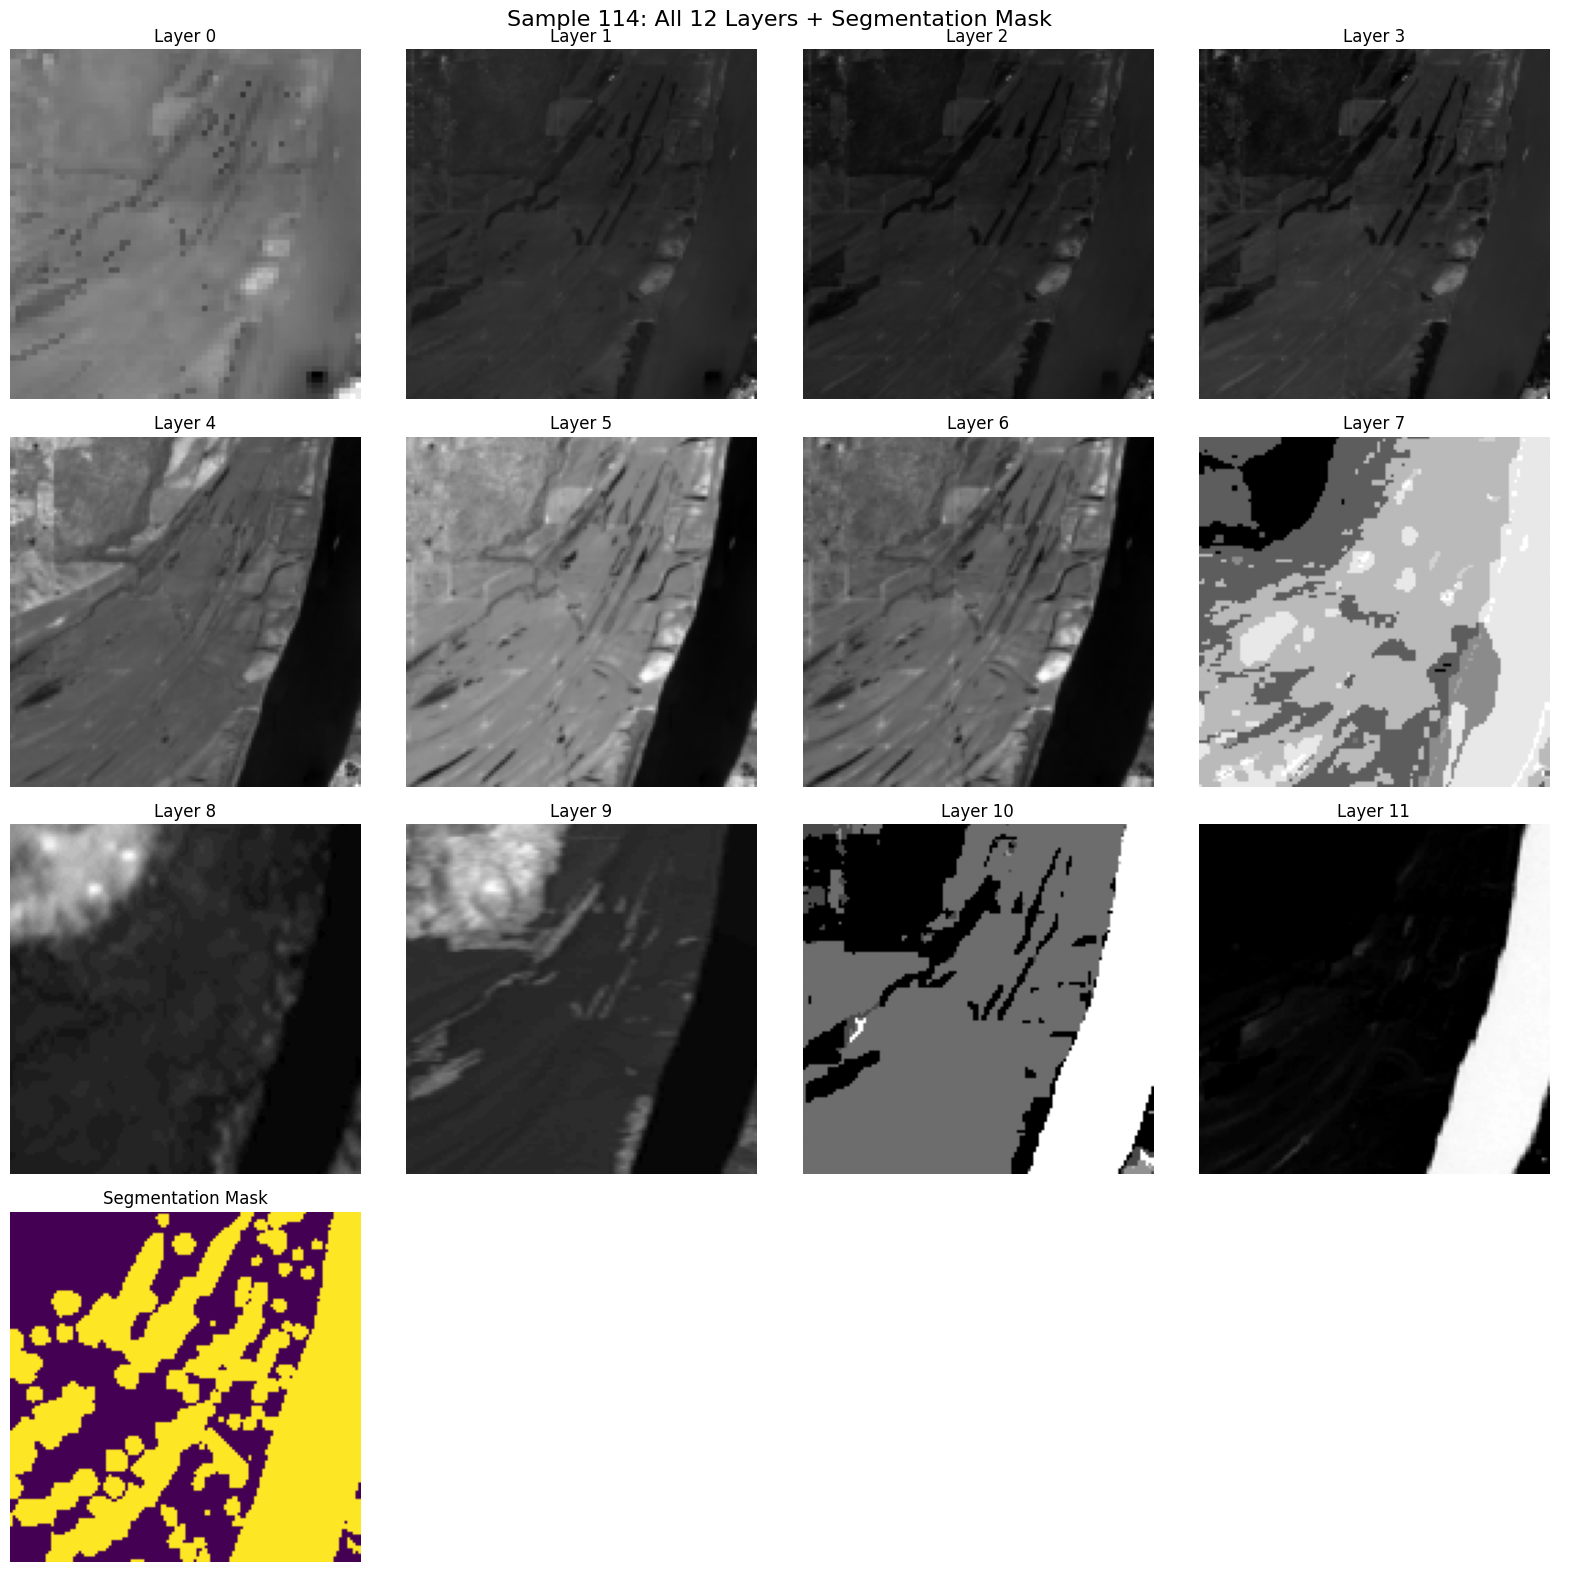

Unique classes in mask: [0 1]
Class distribution: [(np.uint8(0), np.int64(7625)), (np.uint8(1), np.int64(8759))]
Splitting dataset...
Train set: 244 samples
Validation set: 46 samples
Test set: 16 samples
Number of classes: 2

Creating models...

UNet Model Summary:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_125 (Conv2D) │ (None, 128, 128,  │      6,976 │ input_layer_6[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_126 (Conv2D) │ (None, 128, 128,  │     36,928 │ conv2d_125[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 64, 64,    │          0 │ conv2d_126[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_127 (Conv2D) │ (None, 64, 64,    │     73,856 │ max_pooling2d_18… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_128 (Conv2D) │ (None, 64, 64,    │    147,584 │ conv2d_127[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 32, 32,    │          0 │ conv2d_128[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_129 (Conv2D) │ (None, 32, 32,    │    295,168 │ max_pooling2d_19… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_130 (Conv2D) │ (None, 32, 32,    │    590,080 │ conv2d_129[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 16, 16,    │          0 │ conv2d_130[0][0]  │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_131 (Conv2D) │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_20… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_132 (Conv2D) │ (None, 16, 16,    │  2,359,808 │ conv2d_131[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 8, 8, 512) │          0 │ conv2d_132[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_133 (Conv2D) │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_21… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_134 (Conv2D) │ (None, 8, 8,      │  9,438,208 │ conv2d_133[0][0]  │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_16 │ (None, 16, 16,    │  2,097,664 │ conv2d_134[0][0]  │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_20      │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,036,994 (118.40 MB)

 Trainable params: 31,036,994 (118.40 MB)

 Non-trainable params: 0 (0.00 B)


Training UNet...
Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 400ms/step - accuracy: 0.7852 - loss: 0.4246 - val_accuracy: 0.8685 - val_loss: 0.3427 - learning_rate: 0.0010
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - accuracy: 0.8939 - loss: 0.2828 - val_accuracy: 0.8715 - val_loss: 0.3208 - learning_rate: 0.0010
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 0.9071 - loss: 0.2605 - val_accuracy: 0.8738 - val_loss: 0.3317 - learning_rate: 0.0010
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step - accuracy: 0.9080 - loss: 0.2467 - val_accuracy: 0.8766 - val_loss: 0.2914 - learning_rate: 0.0010
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 0.9104 - loss: 0.2264 - val_accuracy: 0.8799 - val_loss: 0.2825 - learning_rate: 0.0010
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.9060 - loss: 0.2332 - val_accuracy: 0.8810 - val_loss: 0.2762 - learning_rate: 0.0010
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 0.918

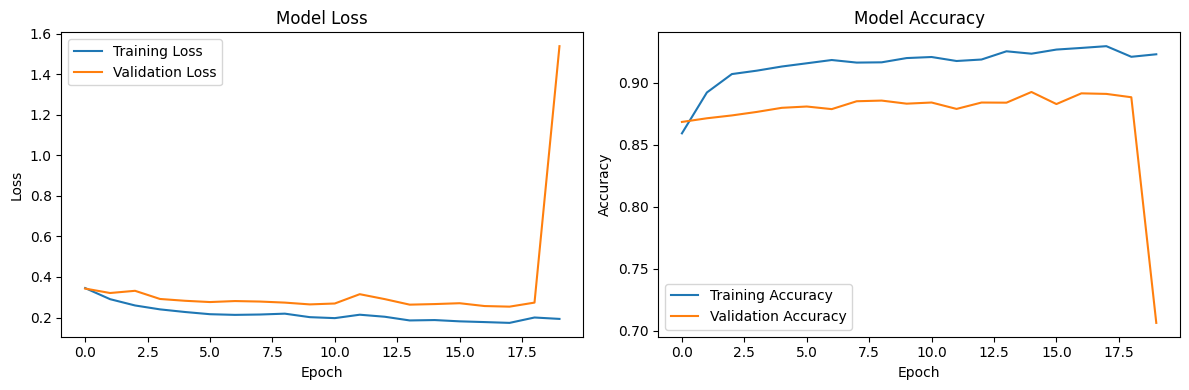


Visualizing predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step


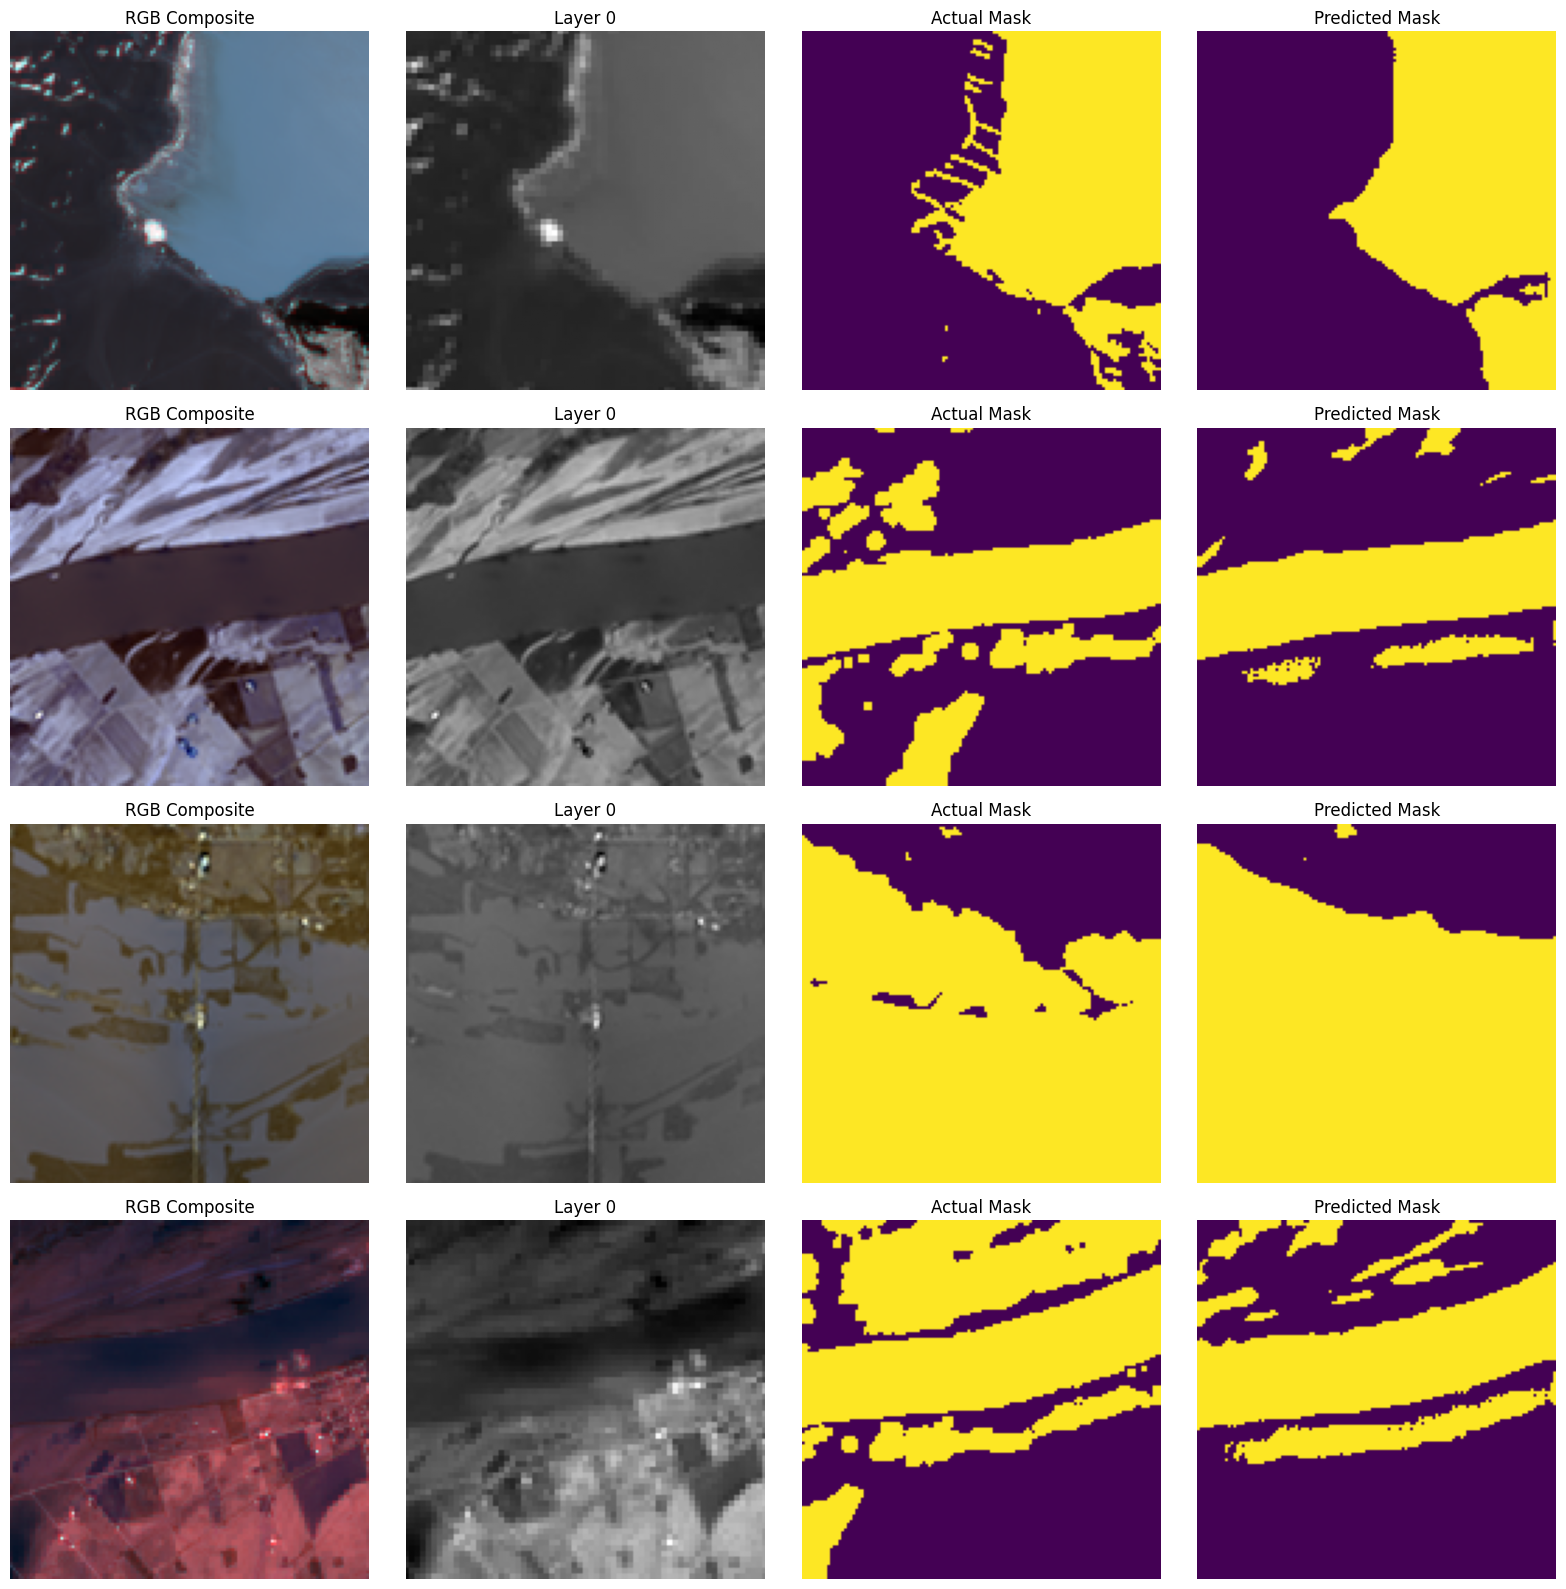


Test Accuracy: 0.8953
Test Loss: 0.2467


In [31]:
if __name__ == '__main__':

    images, masks = load_full_dataset()

    if len(images) > 0:
        visualize_all_layers(images, masks)

        X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(images, masks)

        num_classes = len(np.unique(masks))
        print(f"Number of classes: {num_classes}")

        input_shape = X_train.shape[1:]

        print("\nCreating models...")
        unet = unet_model(input_shape, num_classes)
        attention_unet = attention_unet_model(input_shape, num_classes)
        deeplabv3 = deeplabv3_plus_model(input_shape, num_classes)

        print("\nUNet Model Summary:")
        unet.summary()

        print("\nTraining UNet...")
        history = train_model(unet, X_train, y_train, X_val, y_val, epochs=20)

        plot_training_history(history)

        print("\nVisualizing predictions...")
        visualize_predictions(unet, X_test, y_test, num_samples=4)

        test_loss, test_accuracy = unet.evaluate(X_test, y_test, verbose=0)
        print(f"\nTest Accuracy: {test_accuracy:.4f}")
        print(f"Test Loss: {test_loss:.4f}")



UNet Attention Model Summary:


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_144 (Conv2D) │ (None, 128, 128,  │      6,976 │ input_layer_7[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_145 (Conv2D) │ (None, 128, 128,  │     36,928 │ conv2d_144[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_22    │ (None, 64, 64,    │          0 │ conv2d_145[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_146 (Conv2D) │ (None, 64, 64,    │     73,856 │ max_pooling2d_22… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_147 (Conv2D) │ (None, 64, 64,    │    147,584 │ conv2d_146[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_23    │ (None, 32, 32,    │          0 │ conv2d_147[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_148 (Conv2D) │ (None, 32, 32,    │    295,168 │ max_pooling2d_23… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_149 (Conv2D) │ (None, 32, 32,    │    590,080 │ conv2d_148[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_24    │ (None, 16, 16,    │          0 │ conv2d_149[0][0]  │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_150 (Conv2D) │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_24… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_151 (Conv2D) │ (None, 16, 16,    │  2,359,808 │ conv2d_150[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_25    │ (None, 8, 8, 512) │          0 │ conv2d_151[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_152 (Conv2D) │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_25… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_153 (Conv2D) │ (None, 8, 8,      │  9,438,208 │ conv2d_152[0][0]  │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_20 │ (None, 16, 16,    │  2,097,664 │ conv2d_153[0][0]  │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_154 (Conv2D) │ (None, 16, 16,    │    131,328 │ conv2d_transpose

 Total params: 31,390,454 (119.75 MB)

 Trainable params: 31,388,526 (119.74 MB)

 Non-trainable params: 1,928 (7.53 KB)


Training Attention UNet...
Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 49s 754ms/step - accuracy: 0.7102 - loss: 0.4906 - val_accuracy: 0.8424 - val_loss: 0.3811 - learning_rate: 0.0010
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - accuracy: 0.8968 - loss: 0.2800 - val_accuracy: 0.8703 - val_loss: 0.3262 - learning_rate: 0.0010
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - accuracy: 0.9086 - loss: 0.2472 - val_accuracy: 0.8716 - val_loss: 0.3332 - learning_rate: 0.0010
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - accuracy: 0.9087 - loss: 0.2590 - val_accuracy: 0.7075 - val_loss: 0.5353 - learning_rate: 0.0010
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.9022 - loss: 0.2619 - val_accuracy: 0.8721 - val_loss: 0.3307 - learning_rate: 0.0010
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - accuracy: 0.9136 - loss: 0.2389 - val_accuracy: 0.8717 - val_loss: 0.3194 - learning_rate: 0.0010
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - a

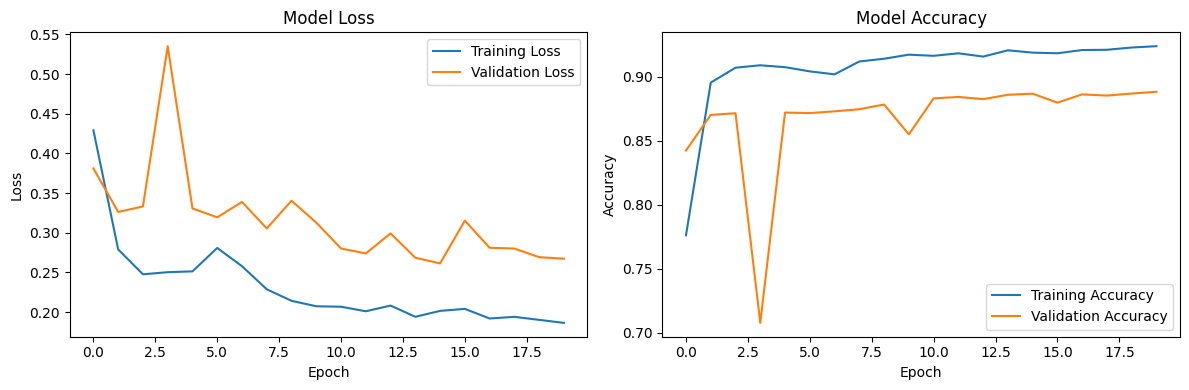

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


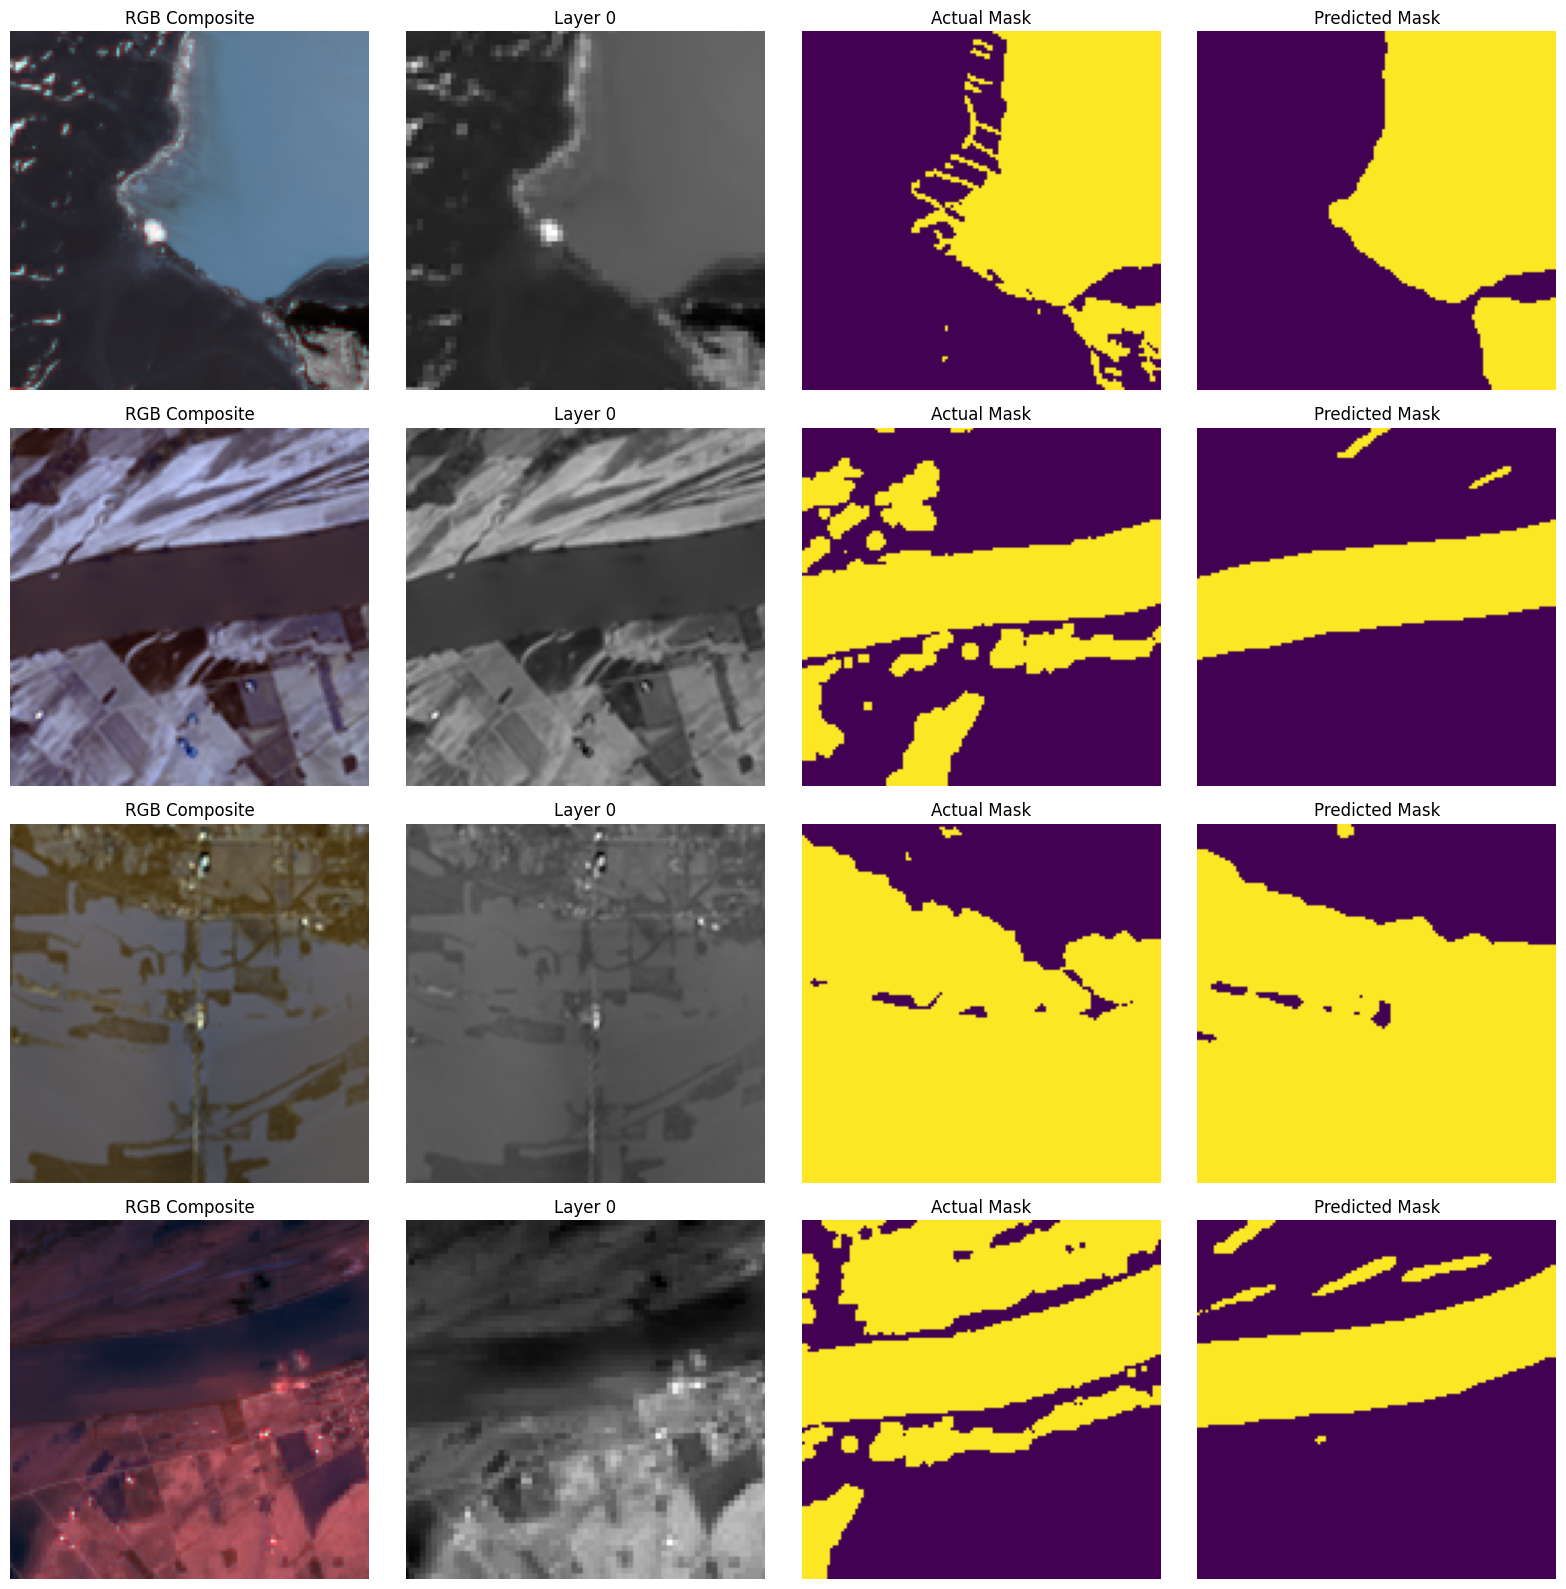


Attention UNet Test Accuracy: 0.8824
Attention UNet Test Loss: 0.2752

DeepLabV3+ Model Summary:


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_175 (Conv2D) │ (None, 64, 64,    │      6,976 │ input_layer_8[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_175[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_176 (Conv2D) │ (None, 64, 64,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_176[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_177 (Conv2D) │ (None, 32, 32,    │     73,856 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_177[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_178 (Conv2D) │ (None, 32, 32,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_178[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 1, 128) │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_183 (Conv2D) │ (None, 1, 1, 256) │     33,024 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_179 (Conv2D) │ (None, 32, 32,    │     33,024 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_180 (Conv2D) │ (None, 32, 32,    │    295,168 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_181 (Conv2D) │ (None, 32, 32,    │    295,168 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_182 (Conv2D) │ (None, 32, 32,    │    295,168 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_5     │ (None, 32, 32,    │          0 │ conv2d_183[0][0]  │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,844,018 (10.85 MB)

 Trainable params: 2,841,618 (10.84 MB)

 Non-trainable params: 2,400 (9.38 KB)


Training DeepLabV3+...
Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.7300 - loss: 0.9095 - val_accuracy: 0.8270 - val_loss: 0.4007 - learning_rate: 0.0010
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 32s 117ms/step - accuracy: 0.8818 - loss: 0.2956 - val_accuracy: 0.8201 - val_loss: 0.3858 - learning_rate: 0.0010
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.8763 - loss: 0.2872 - val_accuracy: 0.7288 - val_loss: 0.5104 - learning_rate: 0.0010
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.8655 - loss: 0.3274 - val_accuracy: 0.8352 - val_loss: 0.5077 - learning_rate: 0.0010
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.8942 - loss: 0.2737 - val_accuracy: 0.7264 - val_loss: 0.4794 - learning_rate: 0.0010
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.9104 - loss: 0.2271 - val_accuracy: 0.7957 - val_loss: 0.4414 - learning_rate: 0.0010
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0

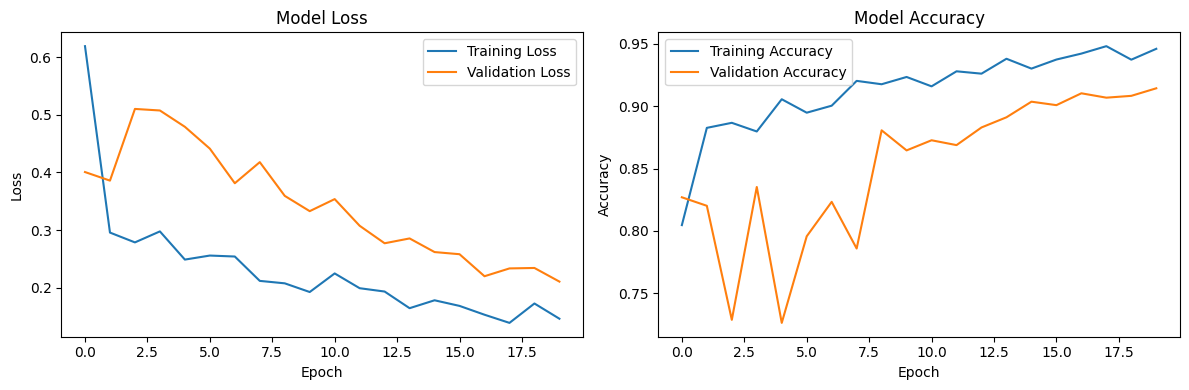

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


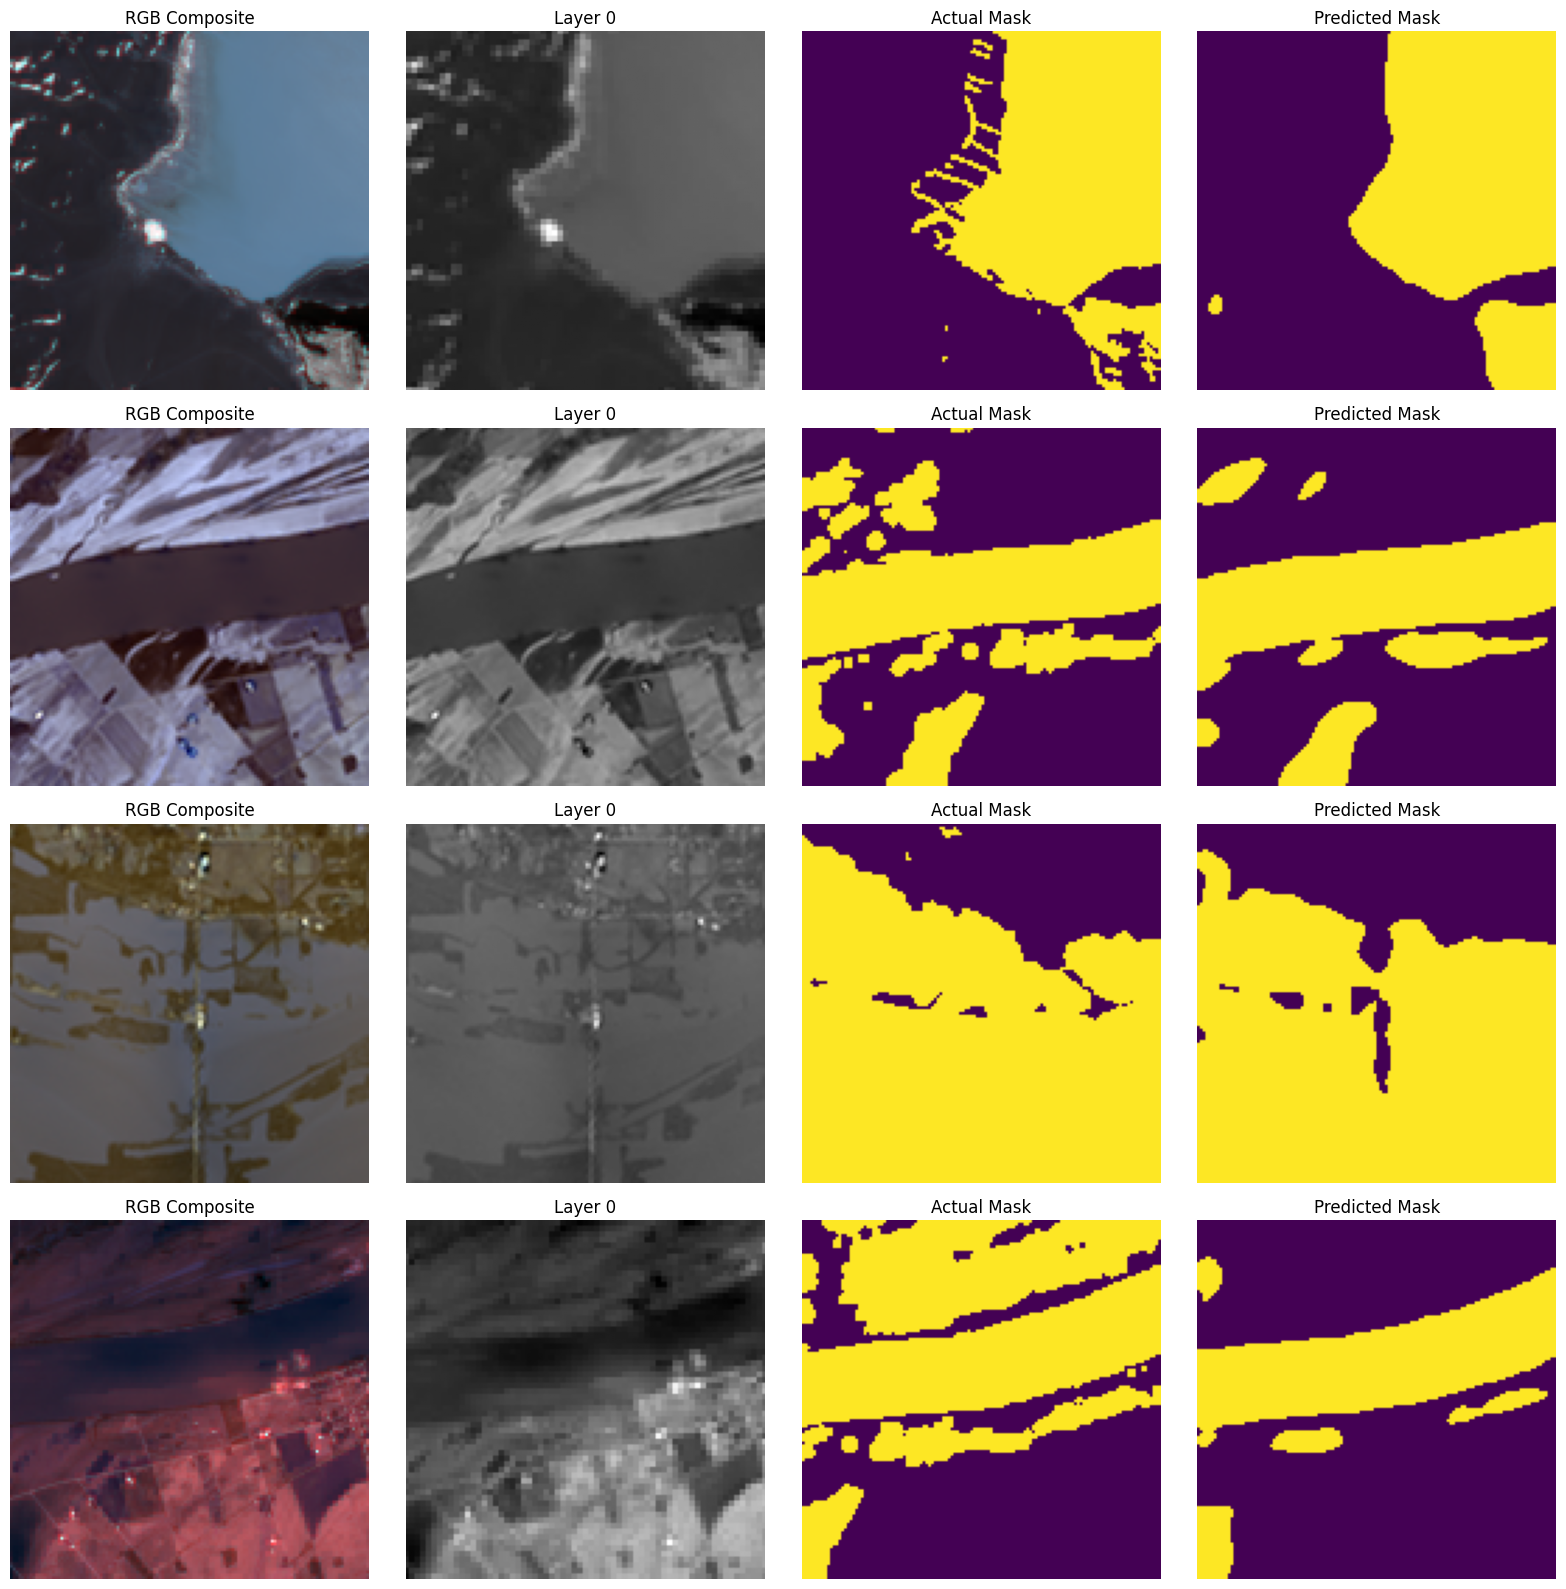


DeepLabV3+ Test Accuracy: 0.8950
DeepLabV3+ Test Loss: 0.2758


In [33]:
print("\nUNet Attention Model Summary:")
attention_unet.summary()
print("\nTraining Attention UNet...")
history_attention = train_model(attention_unet, X_train, y_train, X_val, y_val, epochs=20)
plot_training_history(history_attention)
visualize_predictions(attention_unet, X_test, y_test, num_samples=4)
test_loss_attention, test_accuracy_attention = attention_unet.evaluate(X_test, y_test, verbose=0)
print(f"\nAttention UNet Test Accuracy: {test_accuracy_attention:.4f}")
print(f"Attention UNet Test Loss: {test_loss_attention:.4f}")

print("\nDeepLabV3+ Model Summary:")
deeplabv3.summary()
print("\nTraining DeepLabV3+...")
history_deeplabv3 = train_model(deeplabv3, X_train, y_train, X_val, y_val, epochs=20)
plot_training_history(history_deeplabv3)
visualize_predictions(deeplabv3, X_test, y_test, num_samples=4)
test_loss_deeplabv3, test_accuracy_deeplabv3 = deeplabv3.evaluate(X_test, y_test, verbose=0)
print(f"\nDeepLabV3+ Test Accuracy: {test_accuracy_deeplabv3:.4f}")
print(f"DeepLabV3+ Test Loss: {test_loss_deeplabv3:.4f}")
